In [ ]:
! pip install opendatasets

In [ ]:
import os
import opendatasets as od
import numpy as np # for data manipulation
import pandas as pd # for data manipulation
import random # for data visualization
import matplotlib.pyplot as plt # for data visualization

import cv2
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.measure import moments_hu, shannon_entropy, label as skimage_label, regionprops
from skimage.morphology import skeletonize
from skimage.color import rgb2gray
from skimage import img_as_ubyte, exposure
from scipy.stats import skew, kurtosis

In [ ]:
od.download('https://www.kaggle.com/datasets/ardamavi/27-class-sign-language-dataset/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: farouqanbar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ardamavi/27-class-sign-language-dataset


100%|██████████| 1.06G/1.06G [00:16<00:00, 69.2MB/s]


# Before We Start!

During the previous class (i.e. the one from 15-Nov), some important details were raised by the professor, that will be (at least tried) to be summarized and solved in this newer version of .ipynb file:

## Considerations:
### 1. Dont use PCA as possible input for the model
This mixes up the features, which makes them non traceable.
### 2. Do not use other models besides the Random Forest (from no on, RF)
It is a good enough model. Besides, the idea is to focus more on the data itself rather than the model.
### 3. Focus on Data Processing
As mentioned above, understand the different processes, what they do to the data.
### 4. See the feature ranking of the RF
Special care with this point: Usually the rankings made by the Random Forest models are "unique for each set of features used".
What I mean is that some variables might be considered as non fundamental by the model when it comes to classify the inputs, but when those features are discarded, other features can be considered as non fundamental for this new set of features considered.
### 5. Run for (hopefully) all the data
That is why we moved to Google Colab, to see whether here we are more lucky with respect to this regard. For this, we hope that connecting to the GPU / TPU of offered by Google Colab we might be able to work with the whole of the data set.
### 6. For HOG, speficially, See if the images are centered.
This can already be checked (and, thank God xd) confirmed on the paper:

"[...] Sign Language gestures were placed approximately in the middle of the frame."

In [ ]:
X = np.load('27-class-sign-language-dataset/X.npy')
y = np.load('27-class-sign-language-dataset/Y.npy')

In [ ]:
print(f"Original shapes: X: {X.shape}, y: {y.shape}")

Original shapes: X: (22801, 128, 128, 3), y: (22801, 1)


We will now try to just plot a random image:

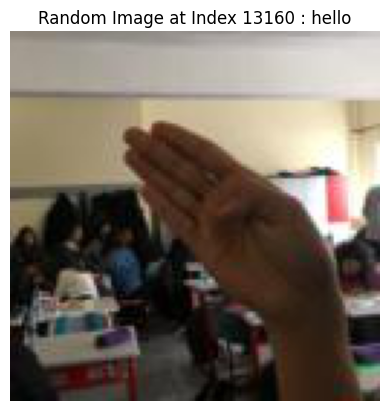

In [ ]:
# Randomly choose an index
random_index = random.randint(0, X.shape[0] - 1)

# Select the image
selected_image = X[random_index]
selected_label = y[random_index][0]

# Display the image (assuming the data is image-like)
plt.imshow(selected_image)  # Adjust dtype if necessary
plt.axis('off')
plt.title(f"Random Image at Index {random_index} : {selected_label}")
plt.show()

original_image = selected_image.copy()

Perfect! Now, we remember the function that follows from the previous .ipynb file.

From the features extracted per image, we have the following that are spatial, and makes sense to want to visualize them:

1. **HOG Features**:

HOG features can be visualized as a grid of gradient orientations overlayed on the image.

2. **Local Binary Patterns (LBP)**:

LBP can be visualized as an image where pixel values represent the computed LBP for that region.

3. **Contours**:

Contours can be drawn on the original image, highlighting the detected contours.

4. **Skeletonization**:

The skeleton can be visualized as a binary image showing the thin structure of the shape.

5. **Convex Hull and Defects**:

The convex hull can be visualized by drawing it over the contour, and defects can be represented as points or segments.

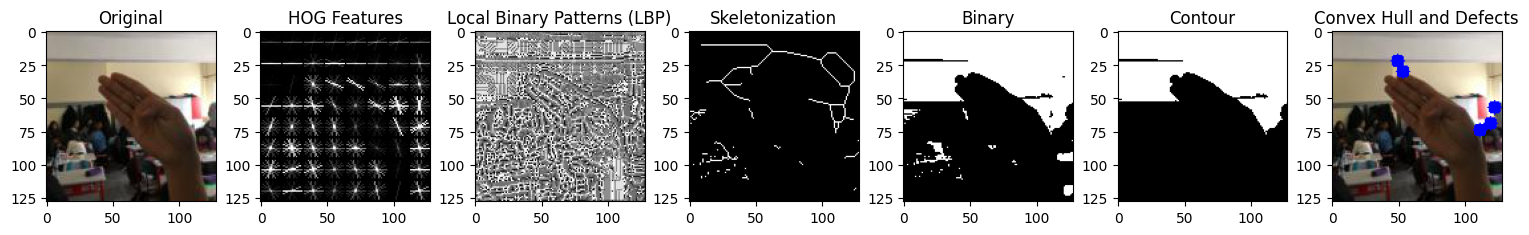

In [ ]:
if selected_image.ndim == 3:
    grayscale_image = rgb2gray(selected_image)
    gray_image_rescaled = np.uint8(grayscale_image * 255)
    _, binary_image = cv2.threshold(gray_image_rescaled, 128, 255, cv2.THRESH_BINARY)
else:
    grayscale_image = selected_image
    gray_image_rescaled = np.uint8(grayscale_image * 255)
    _, binary_image = cv2.threshold(gray_image_rescaled, 128, 255, cv2.THRESH_BINARY)


#### Compute HOG and visualize
hog_features, hog_image = hog(gray_image_rescaled, pixels_per_cell=(16, 16),
                              cells_per_block=(1, 1), visualize=True, channel_axis=None)

#### Rescale HOG image for better visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

#### Compute LBP
lbp_image = local_binary_pattern(gray_image_rescaled, P=8, R=1, method='uniform')

#### Skeletonization
binary_image = grayscale_image > 0.5  # Binarize the image (adjust threshold as needed)
skeleton = skeletonize(binary_image)


#### Finally, Contour & Convex Hull with Defects
_, binary_image = cv2.threshold(gray_image_rescaled, 128, 255, cv2.THRESH_BINARY)

# Second, we go with contour.
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask for the largest contour.
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(binary_image)
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

    # Convexity defects
    hull_points = cv2.convexHull(largest_contour, returnPoints=False)
    defects = cv2.convexityDefects(largest_contour, hull_points)
    if defects is not None:
        for i in range(defects.shape[0]):
            start, end, far, _ = defects[i, 0]
            far_point = tuple(largest_contour[far][0])
            cv2.circle(selected_image, far_point, 5, (0, 0, 255), -1)  # Red for defects


# Display
fig, axs = plt.subplots(ncols=7, nrows=1, figsize=(15, 5), layout='constrained')


axs[0].set_title("Original")
axs[0].imshow(original_image)

axs[1].set_title("HOG Features")
axs[1].imshow(hog_image_rescaled, cmap="gray")

axs[2].set_title("Local Binary Patterns (LBP)")
axs[2].imshow(lbp_image, cmap="gray")

axs[3].set_title("Skeletonization")
axs[3].imshow(skeleton, cmap="gray")

axs[4].set_title("Binary")
axs[4].imshow(binary_image, cmap="gray")

axs[5].set_title("Contour")
axs[5].imshow(mask, cmap="gray")

axs[6].set_title("Convex Hull and Defects")
axs[6].imshow(selected_image)

plt.savefig("processed_images_overview.png", dpi=300, bbox_inches='tight')

plt.show()

# Look at that!

Seems that the images are actually pretty messed up. We need to actually do smth about ligth and all, in order to make them actually usefull.

(Maybe the code was ran later on, but a good image to see how everything is messed uo is the one of the index **17490**, which means number "3").

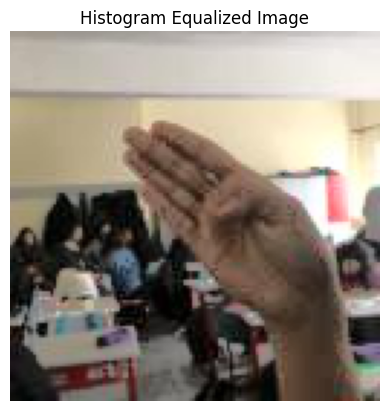

In [ ]:
def equalize_histogram_color(image):
    # Convert to YCrCb color space
    ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    # Convert Y channel to uint8 if necessary and equalize it
    y_channel = ycrcb[:, :, 0]
    ycrcb[:, :, 0] = cv2.equalizeHist(y_channel)

    # Convert back to BGR
    return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)

# Apply to all images
X_equalized = equalize_histogram_color((original_image * 255).astype(np.uint8))

plt.figure()
plt.title("Histogram Equalized Image")
plt.imshow(X_equalized)  # Convert BGR to RGB for visualization
plt.axis("off")
plt.show()

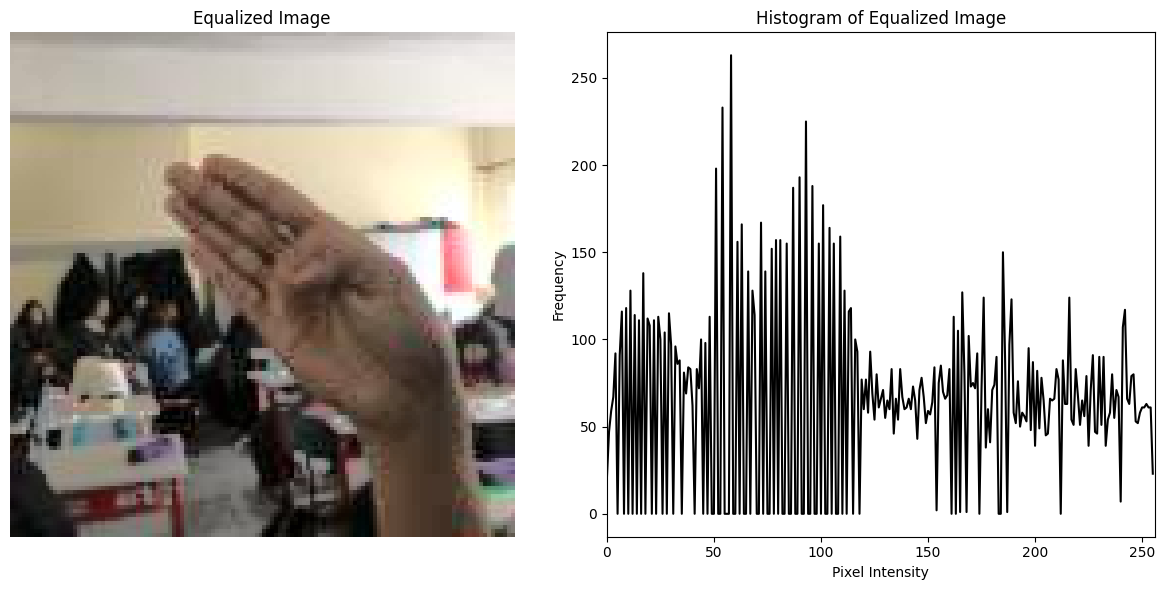

In [ ]:
def fa_equalize_histogram_color(image):
    # Convert to YCrCb color space
    ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    # Equalize the Y channel
    y_channel = ycrcb[:, :, 0]
    ycrcb[:, :, 0] = cv2.equalizeHist(y_channel)

    # Convert back to RGB
    return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)

# Apply histogram equalization to the image
X_equalized = fa_equalize_histogram_color((original_image * 255).astype(np.uint8))

# Calculate the histogram of the equalized image
y_channel = cv2.cvtColor(X_equalized, cv2.COLOR_RGB2YCrCb)[:, :, 0]
hist = cv2.calcHist([y_channel], [0], None, [256], [0, 256])

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the histogram equalized image
axs[0].imshow(X_equalized)
axs[0].set_title("Equalized Image")
axs[0].axis("off")

# Plot the histogram
axs[1].plot(hist, color='black')
axs[1].set_title("Histogram of Equalized Image")
axs[1].set_xlim([0, 256])
axs[1].set_xlabel("Pixel Intensity")
axs[1].set_ylabel("Frequency")

# Show the plots
plt.tight_layout()
plt.show()

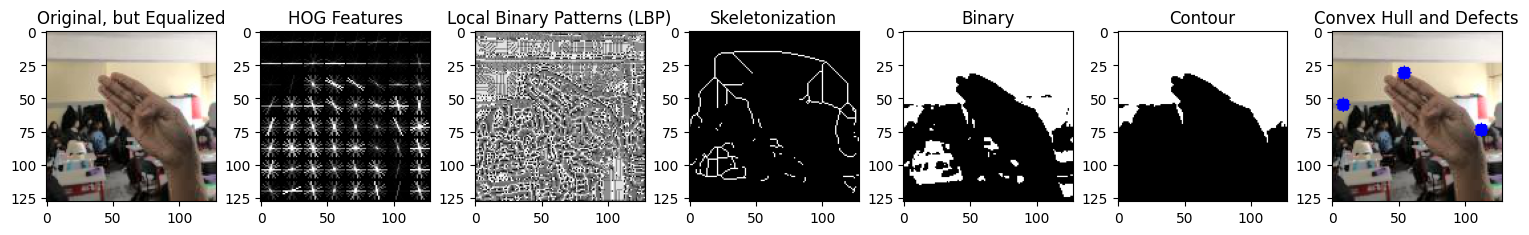

In [ ]:
selected_image = X_equalized.copy()
if selected_image.ndim == 3:
    grayscale_image = rgb2gray(selected_image)
    gray_image_rescaled = np.uint8(grayscale_image * 255)
    _, binary_image = cv2.threshold(gray_image_rescaled, 128, 255, cv2.THRESH_BINARY)
else:
    grayscale_image = selected_image
    gray_image_rescaled = np.uint8(grayscale_image * 255)
    _, binary_image = cv2.threshold(gray_image_rescaled, 128, 255, cv2.THRESH_BINARY)


#### Compute HOG and visualize
hog_features, hog_image = hog(gray_image_rescaled, pixels_per_cell=(16, 16),
                              cells_per_block=(1, 1), visualize=True, channel_axis=None)

#### Rescale HOG image for better visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

#### Compute LBP
lbp_image = local_binary_pattern(gray_image_rescaled, P=8, R=1, method='uniform')

#### Skeletonization
binary_image = grayscale_image > 0.5  # Binarize the image (adjust threshold as needed)
skeleton = skeletonize(binary_image)


#### Finally, Contour & Convex Hull with Defects
_, binary_image = cv2.threshold(gray_image_rescaled, 128, 255, cv2.THRESH_BINARY)

# Second, we go with contour.
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask for the largest contour.
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(binary_image)
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

    # Convexity defects
    hull_points = cv2.convexHull(largest_contour, returnPoints=False)
    defects = cv2.convexityDefects(largest_contour, hull_points)
    if defects is not None:
        for i in range(defects.shape[0]):
            start, end, far, _ = defects[i, 0]
            far_point = tuple(largest_contour[far][0])
            cv2.circle(selected_image, far_point, 5, (0, 0, 255), -1)  # Red for defects


# Display
fig, axs = plt.subplots(ncols = 7, nrows = 1, figsize = (15,5), layout = 'constrained')
axs[0].set_title("Original, but Equalized")
axs[0].imshow(X_equalized)
axs[1].set_title("HOG Features")
axs[1].imshow(hog_image_rescaled, cmap="gray")
axs[2].set_title("Local Binary Patterns (LBP)")
axs[2].imshow(lbp_image, cmap="gray")
axs[3].set_title("Skeletonization")
axs[3].imshow(skeleton, cmap="gray")
axs[4].set_title("Binary")
axs[4].imshow(binary_image, cmap="gray")
axs[5].set_title("Contour")
axs[5].imshow(mask, cmap="gray")
axs[6].set_title("Convex Hull and Defects")
axs[6].imshow(selected_image)
plt.show()

Cualitatively speaking, some of the images *kinda* improved, like the Binary and the Contour image

# Perfect!
Now that we visualized the images, to the moment of truth... Trying all the data.

In [ ]:
def extract_features(image):
    features = {}

    # Convert to grayscale if the image is in color
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # 1. Hu Moments
    hu_moments = moments_hu(image)
    for i, moment in enumerate(hu_moments):
        features[f'hu_moment_{i}'] = moment

    # 2. HOG Features
    hog_features = hog(image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), channel_axis=None)
    hog_features = hog_features.flatten()
    for i, feature in enumerate(hog_features):
        features[f'hog_{i}'] = feature

    # 3. Local Binary Patterns (LBP)
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 60), density=True)  # 59 bins for uniform LBP
    for i, hist_value in enumerate(lbp_hist):
        features[f'lbp_hist_{i}'] = hist_value

    contours, _ = cv2.findContours(img_as_ubyte(image), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)

    # 4. Geometric Shape Features (Contour-based)
    if contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h
        extent = area / (w * h)
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area
        features.update({
            'area': area,
            'perimeter': perimeter,
            'aspect_ratio': aspect_ratio,
            'extent': extent,
            'solidity': solidity
        })

    # 5. Haralick Texture Features (GLCM)
    glcm = graycomatrix(img_as_ubyte(image), distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    features['contrast'] = graycoprops(glcm, 'contrast').mean()
    features['dissimilarity'] = graycoprops(glcm, 'dissimilarity').mean()
    features['homogeneity'] = graycoprops(glcm, 'homogeneity').mean()
    features['energy'] = graycoprops(glcm, 'energy').mean()
    features['correlation'] = graycoprops(glcm, 'correlation').mean()

    # 6. Skeletonization and Finger Count
    skeleton = skeletonize(image > 0.8)
    labeled_skeleton = skimage_label(skeleton)
    features['num_fingers'] = len(regionprops(labeled_skeleton))  # Rough count of fingers as separate regions

    # 7. Convex Hull Defects
    if contours:
        hull_points = cv2.convexHull(cnt, returnPoints=False)
        defects = cv2.convexityDefects(cnt, hull_points)
        features['num_defects'] = len(defects) if defects is not None else 0

    # 8. Statistical Pixel Intensity Features
    pixel_values = image.ravel()
    features['mean_intensity'] = np.mean(pixel_values)
    features['intensity_variance'] = np.var(pixel_values)
    features['intensity_skewness'] = skew(pixel_values)
    features['intensity_kurtosis'] = kurtosis(pixel_values)
    features['entropy'] = shannon_entropy(image)

    return features

In [ ]:
def process_images_to_dataframe(X):
    """
    Processes all images in a NumPy array using the `extract_features` function
    and stores the results in a pandas DataFrame.

    Args:
        X (numpy.ndarray): Array of images with shape (num_images, height, width, channels).

    Returns:
        pandas.DataFrame: DataFrame with extracted features for all images.
    """
    # Initialize an empty list to store feature dictionaries
    feature_list = []

    # Loop over all images in the array
    for i, image in enumerate(X):
        try:
            # Extract features for the current image
            features = extract_features(image)
            feature_list.append(features)
        except Exception as e:
            print(f"Error processing image {i+1}: {e}")
            return i, image  # Return the index and the problematic image

    # Convert the list of feature dictionaries into a DataFrame
    features_df = pd.DataFrame(feature_list)
    return features_df

In [ ]:
# Extract the first 10 images for testing
X_test = X[:10]

test_df = process_images_to_dataframe(X_test)

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [ ]:
test_df.columns

Index(['hu_moment_0', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3',
       'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hog_0', 'hog_1', 'hog_2',
       ...
       'homogeneity', 'energy', 'correlation', 'num_fingers', 'num_defects',
       'mean_intensity', 'intensity_variance', 'intensity_skewness',
       'intensity_kurtosis', 'entropy'],
      dtype='object', length=659)

In [ ]:
test_df.head(10)

,hu_moment_0,hu_moment_1,hu_moment_2,hu_moment_3,hu_moment_4,hu_moment_5,hu_moment_6,hog_0,hog_1,hog_2,...,homogeneity,energy,correlation,num_fingers,num_defects,mean_intensity,intensity_variance,intensity_skewness,intensity_kurtosis,entropy
0,0.257580,0.079605,0.234549,0.137582,0.018887,0.032404,0.015940,0.316479,0.137566,0.285380,...,0.216198,0.018130,0.960140,14,0,0.435617,0.059373,-0.040824,-0.970881,12.548424
1,0.705602,0.509558,0.972339,0.936181,0.893190,0.668260,-0.004051,0.388648,0.388648,0.388648,...,0.338757,0.039302,0.968893,5,0,0.302020,0.064637,1.317872,0.470546,11.471969
2,0.290896,0.084621,0.169242,0.169242,0.028643,0.049232,0.000000,0.391869,0.247749,0.362472,...,0.362009,0.041131,0.978015,27,0,0.339292,0.077736,0.787797,-1.127607,11.015438
3,0.376471,0.138839,0.308769,0.288184,0.080758,0.102021,-0.029463,0.224310,0.198152,0.178077,...,0.163080,0.017099,0.946038,8,0,0.473341,0.026675,-0.033152,0.453775,11.783760
4,0.897467,0.925943,1.944207,1.487175,2.524689,1.430452,-0.144125,0.456405,0.089015,0.149296,...,0.190483,0.024262,0.921459,7,0,0.493583,0.025310,0.771543,2.575982,11.565813
5,1.852022,3.429985,6.918195,6.918195,47.861427,12.812650,0.000000,0.489062,0.000000,0.489062,...,0.529958,0.057041,0.989853,4,0,0.736273,0.042942,-0.859433,-0.215455,9.784690
6,0.427640,0.151015,0.260843,0.364102,0.106023,0.140881,0.036740,0.355053,0.355053,0.355053,...,0.298606,0.040630,0.944052,36,0,0.288841,0.064990,0.692700,-1.001044,11.793227
7,1.840665,3.388048,6.776126,6.776126,45.915466,12.472466,-0.195648,0.562846,0.069154,0.087474,...,0.311538,0.033366,0.978888,8,0,0.510595,0.073653,-0.008723,-0.940464,12.298328
8,0.246067,0.038660,0.105882,0.078688,0.003435,0.012875,0.006308,0.702822,0.053632,0.012732,...,0.172486,0.014931,0.941990,27,1,0.512704,0.077044,-0.362434,-1.100294,12.713417
9,0.197843,0.035010,0.109172,0.094974,0.009669,0.017738,0.000201,0.525077,0.150524,0.062217,...,0.296485,0.033419,0.974584,13,0,0.323428,0.060873,0.643638,-0.584627,11.858297


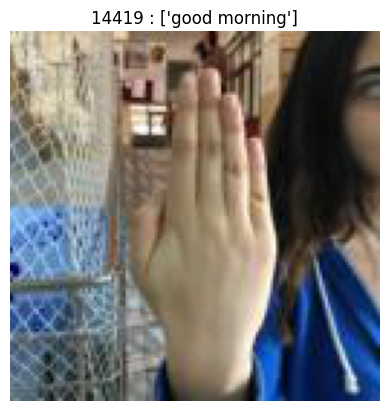

In [ ]:
plt.imshow(X[14419])
plt.axis('off')
plt.title(f"14419 : {y[14419]}")
plt.show()

original_image = selected_image.copy()

In [ ]:
df = process_images_to_dataframe(X)

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Error processing image 13161: Images of type float must be between -1 and 1.


In [ ]:
def process_images_to_dataframe_in_chunks(X, chunk_size=5000):
    """
    Processes images in a NumPy array in chunks using the `extract_features` function
    and stores the results in a pandas DataFrame.

    Args:
        X (numpy.ndarray): Array of images with shape (num_images, height, width, channels).
        chunk_size (int): Number of images to process per iteration.

    Returns:
        pandas.DataFrame: DataFrame with extracted features for all images.
    """
    # Initialize an empty DataFrame to store the results
    features_df = pd.DataFrame()

    num_images = X.shape[0]
    num_chunks = (num_images + chunk_size - 1) // chunk_size  # Calculate the total number of chunks

    for chunk_idx in range(num_chunks):
        print(f"Processing chunk {chunk_idx + 1}/{num_chunks}...")

        # Get the start and end indices for the current chunk
        start_idx = chunk_idx * chunk_size
        end_idx = min(start_idx + chunk_size, num_images)

        # Extract the current chunk
        X_chunk = X[start_idx:end_idx]

        # Process the chunk
        feature_list = []
        for i, image in enumerate(X_chunk):
            try:
                # Extract features for the current image
                features = extract_features(image)
                feature_list.append(features)
            except Exception as e:
                print(f"Error processing image {start_idx + i + 1}: {e}")

        # Convert the chunk's feature list to a DataFrame and append it
        chunk_df = pd.DataFrame(feature_list)
        features_df = pd.concat([features_df, chunk_df], ignore_index=True)

    return features_df

In [ ]:
df = process_images_to_dataframe_in_chunks(X)

Processing chunk 1/5...


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Processing chunk 2/5...
Processing chunk 3/5...
Processing chunk 4/5...
Processing chunk 5/5...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22801 entries, 0 to 22800
Columns: 659 entries, hu_moment_0 to entropy
dtypes: float32(585), float64(72), int64(2)
memory usage: 63.8 MB


In [ ]:
df.head()

,hu_moment_0,hu_moment_1,hu_moment_2,hu_moment_3,hu_moment_4,hu_moment_5,hu_moment_6,hog_0,hog_1,hog_2,...,homogeneity,energy,correlation,num_fingers,num_defects,mean_intensity,intensity_variance,intensity_skewness,intensity_kurtosis,entropy
0,0.257580,0.079605,0.234549,0.137582,0.018887,0.032404,0.015940,0.316479,0.137566,0.285380,...,0.216198,0.018130,0.960140,14,0,0.435617,0.059373,-0.040824,-0.970881,12.548424
1,0.705602,0.509558,0.972339,0.936181,0.893190,0.668260,-0.004051,0.388648,0.388648,0.388648,...,0.338757,0.039302,0.968893,5,0,0.302020,0.064637,1.317872,0.470546,11.471969
2,0.290896,0.084621,0.169242,0.169242,0.028643,0.049232,0.000000,0.391869,0.247749,0.362472,...,0.362009,0.041131,0.978015,27,0,0.339292,0.077736,0.787797,-1.127607,11.015438
3,0.376471,0.138839,0.308769,0.288184,0.080758,0.102021,-0.029463,0.224310,0.198152,0.178077,...,0.163080,0.017099,0.946038,8,0,0.473341,0.026675,-0.033152,0.453775,11.783760
4,0.897467,0.925943,1.944207,1.487175,2.524689,1.430452,-0.144125,0.456405,0.089015,0.149296,...,0.190483,0.024262,0.921459,7,0,0.493583,0.025310,0.771543,2.575982,11.565813


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from scipy.stats import randint

We have to delete the one image we could not extract features out of

In [ ]:
'''
index_to_remove = 13161


y = np.delete(y, index_to_remove, axis=0)

# Verify that the shapes of the DataFrame and npy array align

if len(y) != len(df):
    raise ValueError("The .npy array and DataFrame must have the same number of entries after removal.")

# Step 4: Add the .npy array as the last feature in the DataFrame
df['label'] = npy_array

# Step 5: Save the updated DataFrame
df.to_csv('updated_data.csv', index=False)
'''

In [ ]:

df['label'] = y

# Step 5: Save the updated DataFrame
df.to_csv('features_full.csv', index=False)

In [ ]:
y_model = df['label']  # Labels (target column)
X_model = df.drop('label', axis=1)  # Features (drop the 'label' column)

# Label encoding for the target labels
label_encoder = LabelEncoder()
y_model_encoded = label_encoder.fit_transform(y_model)

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model_encoded, test_size=0.2, random_state=42)

In [ ]:
df.shape, X_train.shape, X_test.shape

((22801, 660), (18240, 659), (4561, 659))

In [ ]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=400, max_depth=15, max_features='sqrt',random_state=42)

# Train the Random Forest Classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optionally, decode the predictions back to original labels if needed
y_pred_labels = label_encoder.inverse_transform(y_pred)

Accuracy: 0.6413
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.68      0.73       202
           1       0.54      0.46      0.49       188
           2       0.44      0.48      0.46       155
           3       0.68      0.61      0.64       178
           4       0.59      0.56      0.57       184
           5       0.62      0.67      0.65       182
           6       0.58      0.46      0.51       168
           7       0.61      0.42      0.49       170
           8       0.55      0.42      0.48       182
           9       0.57      0.48      0.52       177
          10       0.50      0.02      0.04        54
          11       0.69      0.65      0.67       184
          12       0.54      0.59      0.56       149
          13       0.61      0.58      0.59       176
          14       0.74      0.82      0.78       184
          15       0.78      0.78      0.78       167
          16       0.52      0.49      0.

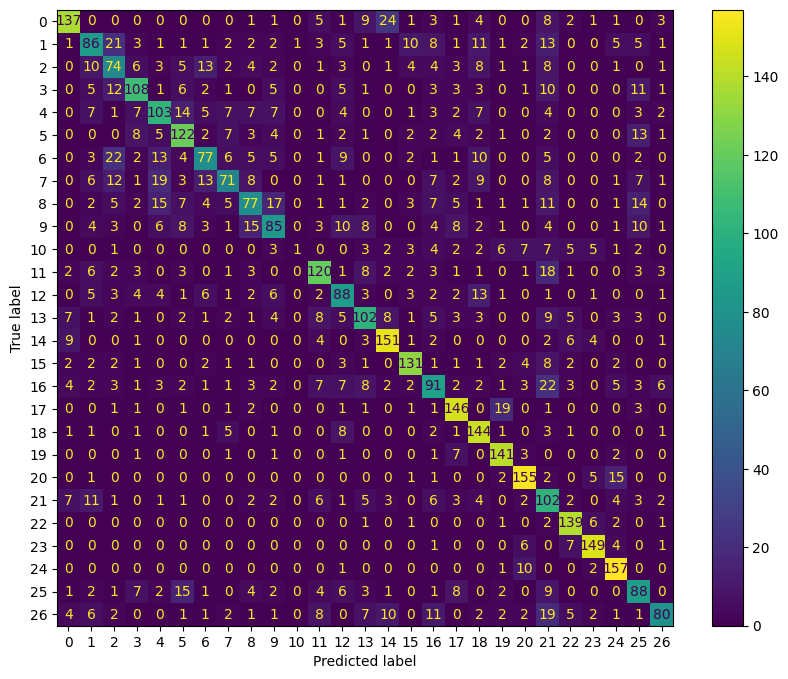

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

fig, axs = plt.subplots(figsize=(10, 8))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = axs)

plt.show()

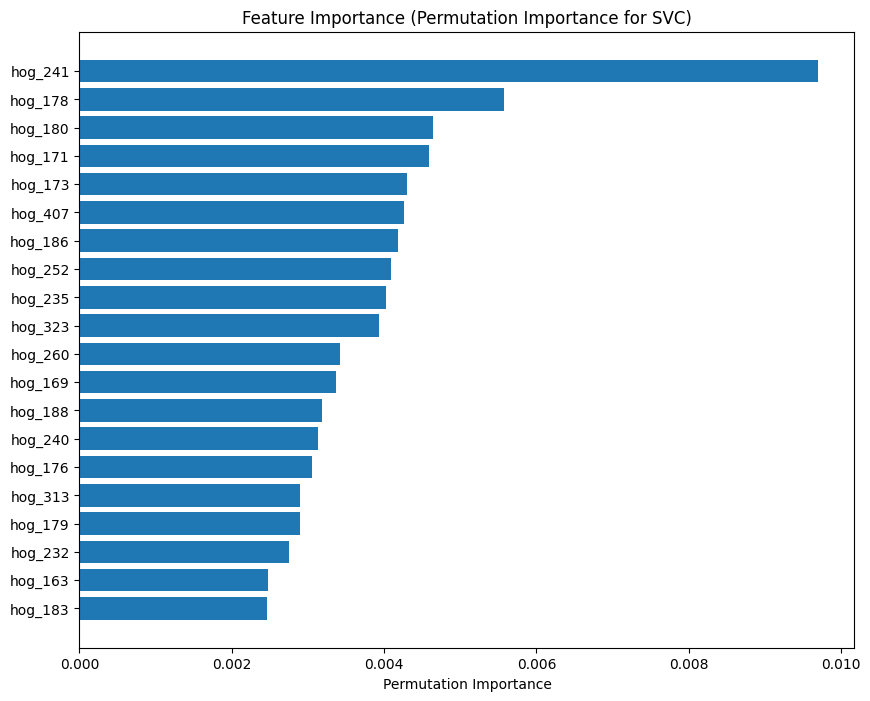

In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(rf_classifier, X_test, y_test, n_repeats=20, random_state=42)

# Sort and plot the top 20 features
sorted_idx = perm_importance.importances_mean.argsort()[-20:]
plt.figure(figsize=(10, 8))
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Permutation Importance for SVC)")
plt.show()

In [ ]:
# Step 1: Identify the indices of the 100 features with the lowest permutation importance
low_importance_idx = perm_importance.importances_mean.argsort()[:600]

# Step 2: Drop these features from your dataset
X_train_reduced = X_train.drop(X_train.columns[low_importance_idx], axis=1)
X_test_reduced = X_test.drop(X_test.columns[low_importance_idx], axis=1)

# Step 3: Retrain the model on the reduced dataset
rf_classifier_reduced = RandomForestClassifier(n_estimators=400, max_depth=15, max_features='sqrt',random_state=42)
rf_classifier_reduced.fit(X_train_reduced, y_train)

# Evaluate the model
y_pred_reduced = rf_classifier_reduced.predict(X_test_reduced)
accuracy = accuracy_score(y_test, y_pred_reduced)
print(f"Accuracy: {accuracy:.4f}")

# Classification report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred_reduced))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_reduced))


Accuracy: 0.5762
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       202
           1       0.48      0.40      0.44       188
           2       0.37      0.41      0.39       155
           3       0.55      0.50      0.53       178
           4       0.56      0.46      0.50       184
           5       0.51      0.54      0.52       182
           6       0.56      0.39      0.46       168
           7       0.50      0.40      0.45       170
           8       0.48      0.45      0.46       182
           9       0.50      0.44      0.47       177
          10       1.00      0.04      0.07        54
          11       0.56      0.61      0.59       184
          12       0.47      0.56      0.51       149
          13       0.51      0.53      0.52       176
          14       0.72      0.74      0.73       184
          15       0.72      0.66      0.69       167
          16       0.42      0.45      0.

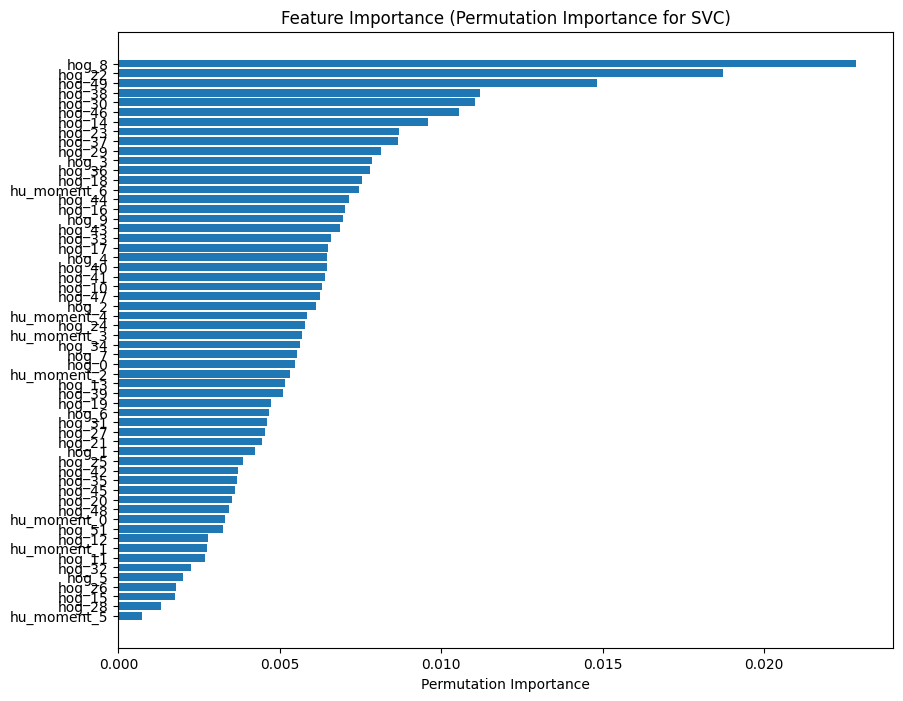

In [ ]:
# Compute permutation importance
perm_importance = permutation_importance(rf_classifier_reduced, X_test_reduced, y_test, n_repeats=20, random_state=42)

# Sort and plot the top 20 features
sorted_idx = perm_importance.importances_mean.argsort()[-58:]
plt.figure(figsize=(10, 8))
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Permutation Importance for SVC)")
plt.show()

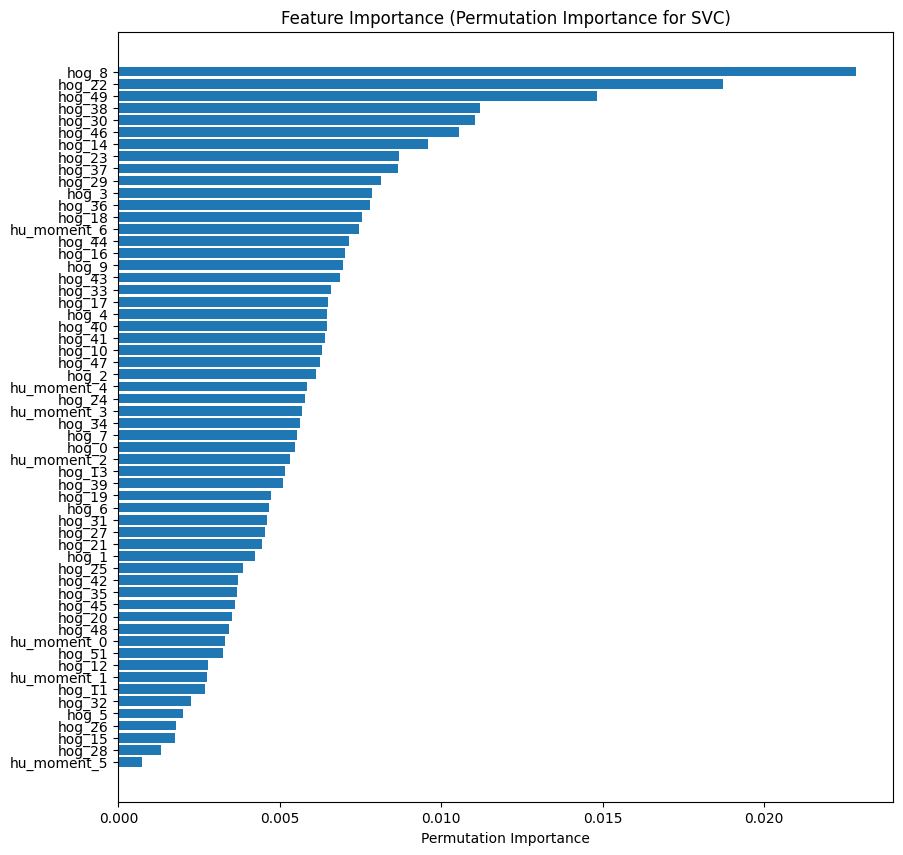

In [ ]:
# Sort and plot the top 20 features
sorted_idx = perm_importance.importances_mean.argsort()[-58:]
plt.figure(figsize=(10, 10))
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Permutation Importance for SVC)")
plt.show()

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()[-58:]
feature_names = X_test.columns[sorted_idx]

print("Feature names with the lowest permutation importance:")
print(feature_names.tolist())

Feature names with the lowest permutation importance:
['hu_moment_5', 'hog_28', 'hog_15', 'hog_26', 'hog_5', 'hog_32', 'hog_11', 'hu_moment_1', 'hog_12', 'hog_51', 'hu_moment_0', 'hog_48', 'hog_20', 'hog_45', 'hog_35', 'hog_42', 'hog_25', 'hog_1', 'hog_21', 'hog_27', 'hog_31', 'hog_6', 'hog_19', 'hog_39', 'hog_13', 'hu_moment_2', 'hog_0', 'hog_7', 'hog_34', 'hu_moment_3', 'hog_24', 'hu_moment_4', 'hog_2', 'hog_47', 'hog_10', 'hog_41', 'hog_40', 'hog_4', 'hog_17', 'hog_33', 'hog_43', 'hog_9', 'hog_16', 'hog_44', 'hu_moment_6', 'hog_18', 'hog_36', 'hog_3', 'hog_29', 'hog_37', 'hog_23', 'hog_14', 'hog_46', 'hog_30', 'hog_38', 'hog_49', 'hog_22', 'hog_8']
